In [1]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

dfs = pd.read_csv("Tokopedia_PlayStore 1000 PlayStore indonesian reviews sentiment.csv", header=0, parse_dates=[0], index_col=0)

In [2]:
def preprocess_comment(comment):
    # Tokenization
    tokens = nltk.word_tokenize(comment)

    # Remove URL/HTTP
    tokens = [re.sub(r'http\S+|www.\S+', '', token) for token in tokens]

    # Remove hashtags
    tokens = [token for token in tokens if not token.startswith('#')]

    # Remove usernames/user mentions
    tokens = [token for token in tokens if not token.startswith('@')]

    # Menghilangkan emotikon
    tokens = [re.sub(r'[^\w\s\d]', '', token) for token in tokens]

    # Remove symbols and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('indonesian'))
    tokens = [token for token in tokens if token not in stopwords]

    # Join tokens back to a single string
    preprocessed_comment = ' '.join(tokens)

    return preprocessed_comment

In [18]:
dfs['sentiment'] = dfs['sentiment'].astype('Int64')

In [19]:
# dfs['sentiment'] = dfs['sentiment'].replace(0, 2)
# dfs['sentiment'] = dfs['sentiment'].replace(1, 0)
dfs['sentiment'] = dfs['sentiment'].replace(-1, 2)

In [13]:
import numpy as np
sentiment_counts = np.bincount(dfs['sentiment'].tolist())

# Print the counts
for sentiment_label, count in enumerate(sentiment_counts):
    print(f"Sentiment {sentiment_label}: {count} occurrences")

Sentiment 0: 310 occurrences
Sentiment 1: 591 occurrences
Sentiment 2: 99 occurrences


In [3]:
dfs['content'] = dfs['content'].apply(preprocess_comment)

In [4]:
dfs

,content,sentiment
0,meresahkan iya sih promonya menarik kurirnya...,-1
1,tingkatkan informasi pelacakan barang kirim i...,0
2,rewel tagih kaya bocah harilambat denda nya ke...,-1
3,kurangin bintang biaya aplikasi,-1
4,suka paket belanja k tokped semoga sukses pak...,1
...,...,...
995,tlong donk tokopedia belanja pas promo free o...,-1
996,mudah mengerti,1
997,kesini gratis ongkir terbatas member gold ad...,-1
998,parah banget skrg kalo checkout biaya layanan ...,-1


In [31]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(dfs['content'],dfs['sentiment'], test_size=0.2, random_state=42)

In [15]:
train = pd.concat([train_texts, train_labels], axis=1)

In [16]:
train.to_csv('tokopedia_playstore_train.csv')

In [7]:
test_labels.to_csv('tokopedia_playstore_test_labels.csv')

In [8]:
test_texts.to_csv('tokopedia_playstore_test_texts.csv')

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

In [22]:
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M', do_lower_case=True)
train_encodings = tokenizer.batch_encode_plus(train_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer.batch_encode_plus(test_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
train_sampler = RandomSampler(train_dataset)
test_sampler = SequentialSampler(test_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=16)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [24]:
model = BertForSequenceClassification.from_pretrained('cahya/bert-base-indonesian-522M', num_labels=3)
optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-ba

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
epochs = 4
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
# Save the BERT main layer
model.save_pretrained('tokopedia_playstore_model')

In [25]:
model = BertForSequenceClassification.from_pretrained('tokopedia_playstore_model')

In [27]:
predictions = []

# Deactivate gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted labels
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions.extend(predicted_labels.detach().cpu().numpy())

# Convert the predictions and true labels into numpy arrays
predictions = np.array(predictions)

In [35]:
predictions_train = []

# Deactivate gradient calculation for inference
with torch.no_grad():
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted labels
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions_train.extend(predicted_labels.detach().cpu().numpy())

# Convert the predictions and true labels into numpy arrays
predictions_train = np.array(predictions)

In [37]:
train = pd.concat([train_texts, train_labels], axis=1)
test = pd.concat([test_texts, test_labels], axis=1)
train = train[:200]
train['hasil_prediksi'] = predictions_train
test['hasil_prediksi'] = predictions

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


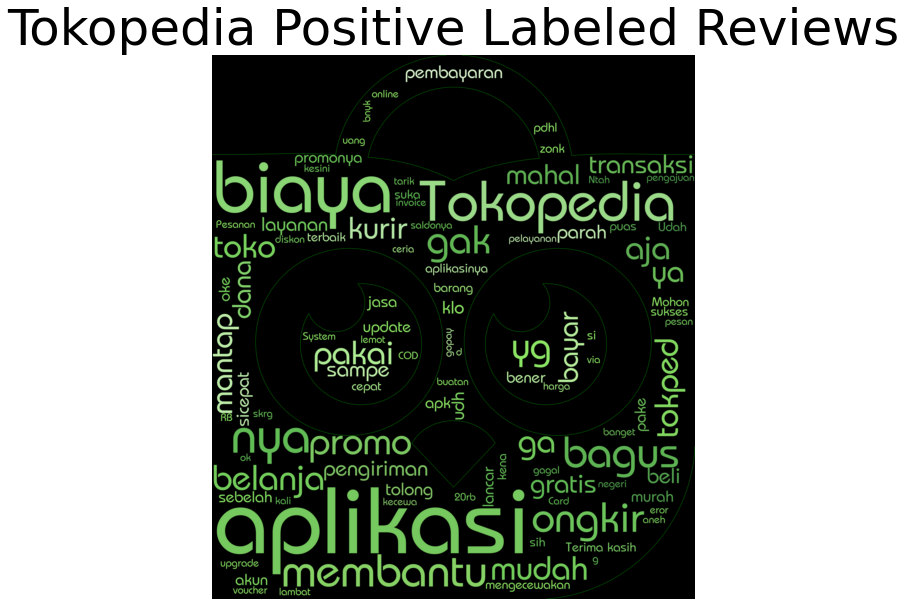

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


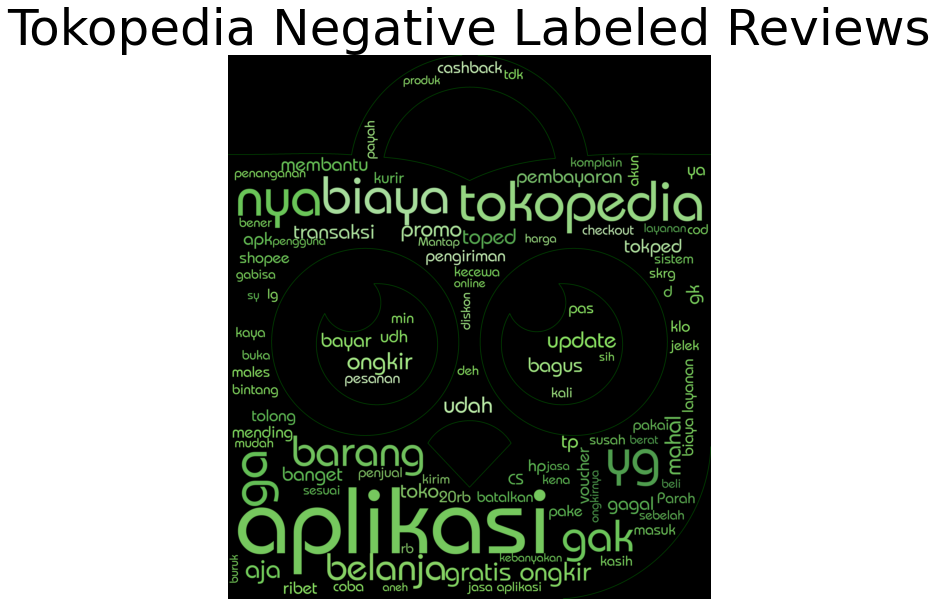

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


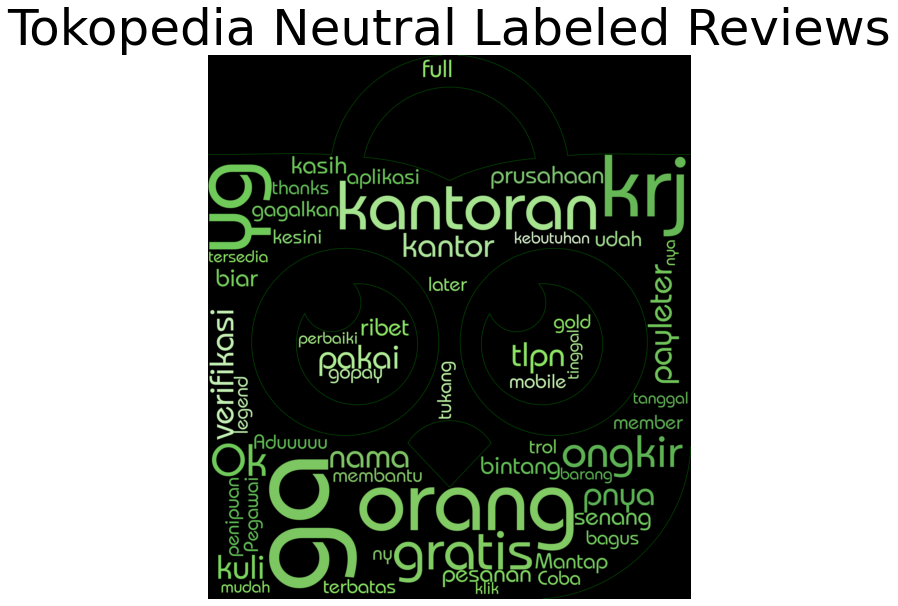

In [38]:
combined_df = pd.concat([train, test])

# List of positive comments (hasil_prediksi == 1)
list_positive_comments = combined_df[combined_df["hasil_prediksi"] == 1]

# List of negative comments (hasil_prediksi == 2)
list_negative_comments = combined_df[combined_df["hasil_prediksi"] == 2]

# List of neutral comments (hasil_prediksi == 0)
list_neutral_comments = combined_df[combined_df["hasil_prediksi"] == 0]

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

import string
import re

def word_cloud(dfs_reviews,sentiment):
    reviews = dfs_reviews.iloc[:,0]
    all_reviews = ' '.join(reviews.astype(str).tolist())
    
    # NLTK tokenization
    words = word_tokenize(all_reviews)

    # Remove symbols and emoticons
    filtered_words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Remove stopwords
    nltk.download('stopwords')
    stopwords_id = set(stopwords.words('indonesian'))
    filtered_words = [word for word in filtered_words if word.lower() not in stopwords_id]

    # manual_sw = ["yg","nya","gak","ga","ya","dr","tp","gk","aja","tokopedia","tokped","aplikasi"]
    # filtered_words = [word for word in filtered_words if word.lower() not in manual_sw]
    filtered_reviews2 = ' '.join(filtered_words)

    # Generate the word cloud with additional parameters
    wordcloud_rsw = WordCloud(
        width=3785,
        height=4267,
        mask=masking,
        background_color='black',
        color_func=colors,
        contour_color='green',
        contour_width=2,
        font_path='BauhausRegular.ttf',
        max_words=100,
        max_font_size=1000
    ).generate(filtered_reviews2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud_rsw, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Tokopedia {sentiment} Reviews', fontsize=50, color='black')
    plt.show()
    
#Create the mask
masking = np.array(Image.open('Tokopedia.png'))

#Grab the mask colors
colors = ImageColorGenerator(masking)

word_cloud(list_positive_comments,sentiment='Positive Labeled')
word_cloud(list_negative_comments,sentiment='Negative Labeled')
word_cloud(list_neutral_comments,sentiment='Neutral Labeled')

In [22]:
predictions = []
true_labels = []

# Deactivate gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get predicted labels
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions.extend(predicted_labels.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Convert the predictions and true labels into numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Generate classification report
target_names = ['neutral', 'positive', 'negative']
classification_rep = classification_report(true_labels, predictions, target_names=target_names)
print(classification_rep)

Accuracy: 0.825
              precision    recall  f1-score   support

     neutral       0.33      0.10      0.15        20
    positive       0.88      0.80      0.84        66
    negative       0.82      0.96      0.89       114

    accuracy                           0.82       200
   macro avg       0.68      0.62      0.63       200
weighted avg       0.79      0.82      0.80       200



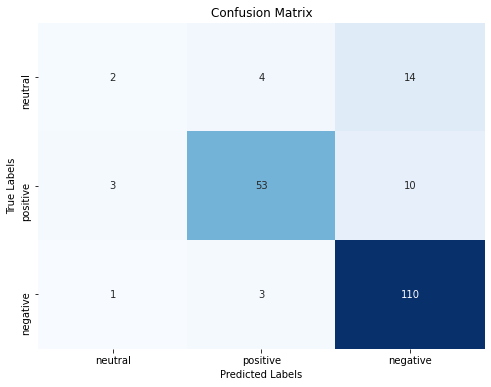

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()